<a href="https://colab.research.google.com/github/FadQode/teks-emo-analysis/blob/main/roberta_can_read_emotion.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# RoBERTa Model Training with Own Dataset

In [ ]:
!apt-get install git

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
git is already the newest version (1:2.34.1-1ubuntu1.11).
0 upgraded, 0 newly installed, 0 to remove and 49 not upgraded.


In [ ]:
!git clone https://github.com/FadQode/teks-emo-analysis

Cloning into 'teks-emo-analysis'...
remote: Enumerating objects: 17, done.
remote: Counting objects: 100% (17/17), done.
remote: Compressing objects: 100% (15/15), done.
remote: Total 17 (delta 3), reused 10 (delta 0), pack-reused 0 (from 0)
Receiving objects: 100% (17/17), 397.94 KiB | 1.46 MiB/s, done.
Resolving deltas: 100% (3/3), done.


## RoBERTa intialiation and Function Definition

### HyperParameter Tuning

In [ ]:
LABEL_MAPPING = {
    'anger': 4,
    'fear': 5,
    'joy': 2,
    'love': 3,
    'sadness': 0,
    'surprise': 1
}


MODEL_NAME = "roberta-base"
BATCH_SIZE = 32
EPOCHS = 20
MAX_LENGTH = 256
LEARNING_RATE = 1e-5

### Dataset Asessing and Preparation

In [ ]:
class EmotionDataset(Dataset):
    def __init__(self, texts, labels, tokenizer, max_length=128):
        self.texts = texts
        self.labels = labels.values.astype(int)
        self.tokenizer = tokenizer
        self.max_length = max_length

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        text = self.texts[idx]
        label = self.labels[idx]
        encoding = self.tokenizer(
            text,
            max_length=self.max_length,
            padding="max_length",
            truncation=True,
            return_tensors="pt"
        )
        return {
            "input_ids": encoding["input_ids"].squeeze(0),
            "attention_mask": encoding["attention_mask"].squeeze(0),
            "label": torch.tensor(label, dtype=torch.long)
        }

In [ ]:
train_data = pd.read_csv("/content/teks-emo-analysis/dataset/emotion_train.csv")
val_data = pd.read_csv("/content/teks-emo-analysis/dataset/emotion_val.csv")
test_data = pd.read_csv("/content/teks-emo-analysis/dataset/emotion_test.csv")

In [ ]:
# Check for missing labels in your train_data
print(train_data["emotion"].isnull().sum())  # Check if there are NaNs

train_data.info()

0
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6784 entries, 0 to 6783
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   text     6784 non-null   object
 1   emotion  6784 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 106.1+ KB


In [ ]:
print(train_data['emotion'].value_counts())

emotion
1    1651
3    1118
4    1108
0    1016
5     962
2     929
Name: count, dtype: int64


In [ ]:
print("Label range in train data:", train_data['emotion'].min(), "-", train_data['emotion'].max())

Label range in train data: 0 - 5


### Defining RoBERTa's Model and Tokenizer

In [ ]:
tokenizer = RobertaTokenizer.from_pretrained(MODEL_NAME)

In [ ]:
train_dataset = EmotionDataset(train_data['text'], train_data['emotion'], tokenizer)
val_dataset = EmotionDataset(val_data['text'], val_data['emotion'], tokenizer)
test_dataset = EmotionDataset(test_data['text'], test_data['emotion'], tokenizer)


In [ ]:
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=16)
test_loader = DataLoader(test_dataset, batch_size=16)

In [ ]:
model = RobertaForSequenceClassification.from_pretrained(MODEL_NAME, num_labels=len(LABEL_MAPPING))
model.to(device)

Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


RobertaForSequenceClassification(
  (roberta): RobertaModel(
    (embeddings): RobertaEmbeddings(
      (word_embeddings): Embedding(50265, 768, padding_idx=1)
      (position_embeddings): Embedding(514, 768, padding_idx=1)
      (token_type_embeddings): Embedding(1, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): RobertaEncoder(
      (layer): ModuleList(
        (0-11): 12 x RobertaLayer(
          (attention): RobertaAttention(
            (self): RobertaSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): RobertaSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
         

### Training the Model

In [ ]:
optimizer = AdamW(model.parameters(), lr=LEARNING_RATE)
num_training_steps = len(train_loader) * EPOCHS
lr_scheduler = get_scheduler("linear", optimizer=optimizer, num_warmup_steps=0, num_training_steps=num_training_steps)


/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:591: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


In [ ]:
def train_model():
    model.train()
    total_loss, total_correct = 0, 0
    for batch in tqdm(train_loader):
        batch = {key: val.to(device) for key, val in batch.items()}

        outputs = model(
            input_ids=batch["input_ids"],
            attention_mask=batch["attention_mask"],
            labels=batch["label"]
        )

        loss = outputs.loss
        logits = outputs.logits

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        lr_scheduler.step()

        total_loss += loss.item()
        total_correct += (logits.argmax(dim=1) == batch["label"]).sum().item()

    avg_loss = total_loss / len(train_loader)
    accuracy = total_correct / len(train_dataset)
    print(f"Training loss: {avg_loss:.4f}, Accuracy: {accuracy:.4f}")

In [ ]:
def evaluate_model():
    model.eval()
    total_loss, total_correct = 0, 0
    with torch.no_grad():
        for batch in tqdm(val_loader):
            batch = {key: val.to(device) for key, val in batch.items()}

            outputs = model(
                input_ids=batch["input_ids"],
                attention_mask=batch["attention_mask"],
                labels=batch["label"]
            )

            loss = outputs.loss
            logits = outputs.logits

            total_loss += loss.item()
            total_correct += (logits.argmax(dim=1) == batch["label"]).sum().item()

    avg_loss = total_loss / len(val_loader)
    accuracy = total_correct / len(val_dataset)
    print(f"Validation loss: {avg_loss:.4f}, Accuracy: {accuracy:.4f}")


In [ ]:
def evaluate_model():
    model.eval()
    all_labels, all_preds = [], []
    with torch.no_grad():
        for batch in tqdm(val_loader):
            batch = {key: val.to(device) for key, val in batch.items()}
            outputs = model(input_ids=batch["input_ids"], attention_mask=batch["attention_mask"])
            logits = outputs.logits
            preds = logits.argmax(dim=1).cpu().numpy()
            labels = batch["label"].cpu().numpy()
            all_labels.extend(labels)
            all_preds.extend(preds)

    report = classification_report(all_labels, all_preds, target_names=list(LABEL_MAPPING.keys()))
    print(report)

In [ ]:
for epoch in range(EPOCHS):
    print(f"Epoch {epoch + 1}/{EPOCHS}")
    train_model()
    evaluate_model()


Epoch 1/20


100%|██████████| 424/424 [02:30<00:00,  2.81it/s]


Training loss: 0.6841, Accuracy: 0.7619


100%|██████████| 97/97 [00:10<00:00,  9.18it/s]


Validation loss: 0.6555, Accuracy: 0.7828
Epoch 2/20


100%|██████████| 424/424 [02:30<00:00,  2.82it/s]


Training loss: 0.4867, Accuracy: 0.8404


100%|██████████| 97/97 [00:10<00:00,  9.11it/s]


Validation loss: 0.5803, Accuracy: 0.8119
Epoch 3/20


100%|██████████| 424/424 [02:30<00:00,  2.82it/s]


Training loss: 0.3711, Accuracy: 0.8796


100%|██████████| 97/97 [00:10<00:00,  9.11it/s]


Validation loss: 0.5716, Accuracy: 0.8216
Epoch 4/20


100%|██████████| 424/424 [02:30<00:00,  2.82it/s]


Training loss: 0.3304, Accuracy: 0.8909


100%|██████████| 97/97 [00:10<00:00,  9.07it/s]


Validation loss: 0.5347, Accuracy: 0.8371
Epoch 5/20


100%|██████████| 424/424 [02:30<00:00,  2.82it/s]


Training loss: 0.2739, Accuracy: 0.9091


100%|██████████| 97/97 [00:10<00:00,  9.16it/s]


Validation loss: 0.5399, Accuracy: 0.8416
Epoch 6/20


100%|██████████| 424/424 [02:30<00:00,  2.82it/s]


Training loss: 0.2429, Accuracy: 0.9203


100%|██████████| 97/97 [00:10<00:00,  9.08it/s]


Validation loss: 0.5776, Accuracy: 0.8365
Epoch 7/20


100%|██████████| 424/424 [02:30<00:00,  2.82it/s]


Training loss: 0.2159, Accuracy: 0.9291


100%|██████████| 97/97 [00:10<00:00,  9.09it/s]


Validation loss: 0.5697, Accuracy: 0.8442
Epoch 8/20


100%|██████████| 424/424 [02:30<00:00,  2.82it/s]


Training loss: 0.1851, Accuracy: 0.9406


100%|██████████| 97/97 [00:10<00:00,  9.10it/s]


Validation loss: 0.5970, Accuracy: 0.8390
Epoch 9/20


100%|██████████| 424/424 [02:30<00:00,  2.82it/s]


Training loss: 0.1571, Accuracy: 0.9481


100%|██████████| 97/97 [00:10<00:00,  9.05it/s]


Validation loss: 0.6181, Accuracy: 0.8197
Epoch 10/20


100%|██████████| 424/424 [02:30<00:00,  2.82it/s]


Training loss: 0.1294, Accuracy: 0.9595


100%|██████████| 97/97 [00:10<00:00,  9.14it/s]


Validation loss: 0.6771, Accuracy: 0.8300
Epoch 11/20


100%|██████████| 424/424 [02:30<00:00,  2.82it/s]


Training loss: 0.1100, Accuracy: 0.9645


100%|██████████| 97/97 [00:10<00:00,  9.08it/s]


Validation loss: 0.6857, Accuracy: 0.8339
Epoch 12/20


100%|██████████| 424/424 [02:30<00:00,  2.82it/s]


Training loss: 0.0939, Accuracy: 0.9707


100%|██████████| 97/97 [00:10<00:00,  9.17it/s]


Validation loss: 0.7081, Accuracy: 0.8326
Epoch 13/20


100%|██████████| 424/424 [02:30<00:00,  2.82it/s]


Training loss: 0.0797, Accuracy: 0.9752


100%|██████████| 97/97 [00:11<00:00,  8.64it/s]


Validation loss: 0.7407, Accuracy: 0.8300
Epoch 14/20


100%|██████████| 424/424 [02:33<00:00,  2.77it/s]


Training loss: 0.0657, Accuracy: 0.9808


100%|██████████| 97/97 [00:10<00:00,  9.08it/s]


Validation loss: 0.7320, Accuracy: 0.8300
Epoch 15/20


100%|██████████| 424/424 [02:30<00:00,  2.81it/s]


Training loss: 0.0577, Accuracy: 0.9830


100%|██████████| 97/97 [00:10<00:00,  9.15it/s]


Validation loss: 0.7352, Accuracy: 0.8358
Epoch 16/20


100%|██████████| 424/424 [02:30<00:00,  2.82it/s]


Training loss: 0.0530, Accuracy: 0.9828


100%|██████████| 97/97 [00:10<00:00,  9.13it/s]


Validation loss: 0.7606, Accuracy: 0.8345
Epoch 17/20


100%|██████████| 424/424 [02:30<00:00,  2.82it/s]


Training loss: 0.0464, Accuracy: 0.9864


100%|██████████| 97/97 [00:10<00:00,  9.14it/s]


Validation loss: 0.7672, Accuracy: 0.8339
Epoch 18/20


100%|██████████| 424/424 [02:30<00:00,  2.82it/s]


Training loss: 0.0425, Accuracy: 0.9881


100%|██████████| 97/97 [00:10<00:00,  9.11it/s]


Validation loss: 0.7645, Accuracy: 0.8306
Epoch 19/20


100%|██████████| 424/424 [02:30<00:00,  2.82it/s]


Training loss: 0.0363, Accuracy: 0.9915


100%|██████████| 97/97 [00:10<00:00,  9.18it/s]


Validation loss: 0.7667, Accuracy: 0.8352
Epoch 20/20


100%|██████████| 424/424 [02:30<00:00,  2.82it/s]


Training loss: 0.0369, Accuracy: 0.9897


100%|██████████| 97/97 [00:10<00:00,  9.13it/s]

Validation loss: 0.7667, Accuracy: 0.8352


## RoBERTa Model Saving

In [ ]:
model.save_pretrained("./roberta_emotion_model")
tokenizer.save_pretrained("./roberta_emotion_model")

('./roberta_emotion_model/tokenizer_config.json',
 './roberta_emotion_model/special_tokens_map.json',
 './roberta_emotion_model/vocab.json',
 './roberta_emotion_model/merges.txt',
 './roberta_emotion_model/added_tokens.json')

In [ ]:
from google.colab import userdata
from huggingface_hub import login
from huggingface_hub import Repository

# Initialize your model and tokenizer
model = RobertaForSequenceClassification.from_pretrained("/content/roberta_emotion_model")
tokenizer = RobertaTokenizer.from_pretrained("/content/roberta_emotion_model")

# Create a directory to store your model and tokenizer
repo_name = "FadQ/Roberta-can-read-emotion"
repo = Repository(local_dir=repo_name, clone_from=repo_name)

# Save the model and tokenizer to the directory
model.save_pretrained(repo_name)
tokenizer.save_pretrained(repo_name)


# Push to Hugging Face Hub
repo.push_to_hub(commit_message="Initial model upload")

In [ ]:
print(test_data["emotion"].isnull().sum())  # Should be 0
test_data.info()

0
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1547 entries, 0 to 1546
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   text     1547 non-null   object
 1   emotion  1547 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 24.3+ KB


## Test roBERTa trained model with antoher data


### Test Set

In [ ]:
def predict_emotion_batch(texts):
    """Predict emotions for a batch of texts."""
    encoding = tokenizer(
        texts,
        max_length=128,
        padding=True,  # Batch padding
        truncation=True,
        return_tensors="pt"
    )

    input_ids = encoding["input_ids"].to('cuda' if torch.cuda.is_available() else 'cpu')
    attention_mask = encoding["attention_mask"].to('cuda' if torch.cuda.is_available() else 'cpu')

    with torch.no_grad():
        outputs = model(input_ids, attention_mask=attention_mask)
        logits = outputs.logits
        predictions = torch.argmax(logits, dim=1).cpu().numpy()

    return predictions


In [ ]:
all_texts = test_data['text'].tolist()
true_labels = test_data['emotion'].values

# Predict in batches to avoid memory issues
BATCH_SIZE = 16  # Can be adjusted depending on your hardware
predicted_labels = []

for i in range(0, len(all_texts), BATCH_SIZE):
    batch_texts = all_texts[i:i + BATCH_SIZE]
    batch_predictions = predict_emotion_batch(batch_texts)
    predicted_labels.extend(batch_predictions)

# Step 5: Calculate accuracy
accuracy = (np.array(predicted_labels) == true_labels).mean()
print(f"Test Accuracy: {accuracy * 100:.2f}%")

Test Accuracy: 84.16%


### Input Teks

In [ ]:
MODEL_DIR = "roberta-base"
# Load the model and tokenizer
tokenizer = RobertaTokenizer.from_pretrained(MODEL_DIR)
model_input = RobertaForSequenceClassification.from_pretrained(MODEL_DIR)
model_input.eval()  # Set to evaluation mode


LABEL_MAPPING = {
    0: 'sadness',
    1: 'surprise',
    2: 'joy',
    3: 'love',
    4: 'anger',
    5: 'fear'
}

def predict_emotion(diary_text):
    """Predicts the emotion for a given diary text."""
    encoding = tokenizer(
        diary_text,
        max_length=128,
        padding="max_length",
        truncation=True,
        return_tensors="pt"
    )

    input_ids = encoding["input_ids"]
    attention_mask = encoding["attention_mask"]

    with torch.no_grad():
        outputs = model_input(input_ids, attention_mask=attention_mask)
        logits = outputs.logits
        predicted_class = torch.argmax(logits, dim=1).item()
        predicted_emotion = LABEL_MAPPING[predicted_class]

    return predicted_emotion


# Input a diary text and predict its emotion
diary_text = input("Enter your diary text: ")
predicted_emotion = predict_emotion(diary_text)
print(f"The predicted emotion is: {predicted_emotion}")

Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Enter your diary text: Diary  Tanggal: 14 Desember 2024  Hari ini aku sedih, uangku tambah banyak.namun aku bingung mau menghabiskan bagaimana. kemudian temanku datang dan dipalak   End of Diary.
The predicted emotion is: sadness


In [ ]:
import shutil

# Specify the folder to zip
folder_to_zip = 'roberta_emotion_model'

# Create a zip file
shutil.make_archive('roberta_model', 'zip', folder_to_zip)

'/content/teks-emo-analysis/roberta_model.zip'

In [ ]:
!git rm -r roberta_emotion_model

rm 'roberta_emotion_model/merges.txt'
rm 'roberta_emotion_model/model.safetensors'
rm 'roberta_emotion_model/special_tokens_map.json'
rm 'roberta_emotion_model/tokenizer_config.json'
rm 'roberta_emotion_model/vocab.json'


In [ ]:
from google.colab import files

# Download the zip file
files.download('roberta_model.zip')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
!du -sh roberta_model.zip

405M	roberta_model.zip


In [ ]:
from google.colab import drive
drive.mount('/content/drive')
shutil.move('roberta_model.zip', '/content/drive/MyDrive/')

Mounted at /content/drive


'/content/drive/MyDrive/roberta_model.zip'

# Fine Tune Gemma with Counseling Dataset

In [ ]:
%pip install -U -q datasets trl bitsandbytes transformers accelerate peft wandb gradio

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.5/43.5 kB 2.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 480.6/480.6 kB 16.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 365.7/365.7 kB 27.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 69.1/69.1 MB 16.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 336.4/336.4 kB 23.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 374.8/374.8 kB 30.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 20.0/20.0 MB 94.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 57.2/57.2 MB 11.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 320.4/320.4 kB 24.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 11.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 94.8/94.8 kB 8.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 179.3/179.3 kB 16.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

In [ ]:
!pip uninstall bitsandbytes

Found existing installation: bitsandbytes 0.45.0
Uninstalling bitsandbytes-0.45.0:
  Would remove:
    /usr/local/lib/python3.10/dist-packages/bitsandbytes-0.45.0.dist-info/*
    /usr/local/lib/python3.10/dist-packages/bitsandbytes/*
    /usr/local/lib/python3.10/dist-packages/tests/*
  Would not remove (might be manually added):
    /usr/local/lib/python3.10/dist-packages/tests/slow/__init__.py
    /usr/local/lib/python3.10/dist-packages/tests/slow/test_dpo_slow.py
    /usr/local/lib/python3.10/dist-packages/tests/slow/test_sft_slow.py
    /usr/local/lib/python3.10/dist-packages/tests/slow/testing_constants.py
    /usr/local/lib/python3.10/dist-packages/tests/test_best_of_n_sampler.py
    /usr/local/lib/python3.10/dist-packages/tests/test_cli.py
    /usr/local/lib/python3.10/dist-packages/tests/test_core.py
    /usr/local/lib/python3.10/dist-packages/tests/test_cpo_trainer.py
    /usr/local/lib/python3.10/dist-packages/tests/test_data_collator_completion_only.py
    /usr/local/lib/pyt

In [ ]:
!pip install -U bitsandbytes
!pip install -U transformers
!pip install torch --upgrade

  Using cached bitsandbytes-0.45.0-py3-none-manylinux_2_24_x86_64.whl.metadata (2.9 kB)
Using cached bitsandbytes-0.45.0-py3-none-manylinux_2_24_x86_64.whl (69.1 MB)
  Using cached transformers-4.47.0-py3-none-any.whl.metadata (43 kB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.1/10.1 MB 42.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.0/3.0 MB 83.7 MB/s eta 0:00:00
  Attempting uninstall: tokenizers
    Found existing installation: tokenizers 0.20.3
    Uninstalling tokenizers-0.20.3:
      Successfully uninstalled tokenizers-0.20.3
  Attempting uninstall: transformers
    Found existing installation: transformers 4.46.3
    Uninstalling transformers-4.46.3:
      Successfully uninstalled transformers-4.46.3
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
trl 0.12.2 requires transformers<4.47.0, but you have transformers 4.47.0 which is i

## LLM Setup and Paramater Tuning wih QLORA

### Library Import

In [ ]:
from transformers import (
    AutoModelForCausalLM,
    AutoTokenizer,
    BitsAndBytesConfig,
    HfArgumentParser,
    TrainingArguments,
    pipeline,
    logging,
)
from peft import (
    LoraConfig,
    PeftModel,
    prepare_model_for_kbit_training,
    get_peft_model,
)
import os, torch, wandb
from datasets import load_dataset
from trl import SFTTrainer, SFTConfig

from google.colab import userdata
from huggingface_hub import login

### WandB and Hugging Face Setup

In [ ]:
hf_token = userdata.get("HF_SECRET")
wb_token = userdata.get("WB_SECRET")

login(token=hf_token)
wandb.login(key=wb_token)

run = wandb.init(
    project="Fine-tune Gemma 2B on Mental-Console Chatbot Dataset",
    job_type="training",
    anonymous="allow"
)

wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.
wandb: Currently logged in as: fadhileq28 (fadhileq28-universitas-muhammadiyah-surakarta). Use `wandb login --relogin` to force relogin
wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


### QLoRA Config

In [ ]:
bnb_config = BitsAndBytesConfig(
    load_in_4bit=True,
    bnb_4bit_quant_type="nf4",
    bnb_4bit_compute_dtype=torch.bfloat16,
    bnb_4bit_use_double_quant=True
)

base_model = "google/gemma-2b-it"

model = AutoModelForCausalLM.from_pretrained(
    base_model,
    quantization_config=bnb_config,
    device_map='auto'
)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/627 [00:00<?, ?B/s]

model.safetensors.index.json:   0%|          | 0.00/13.5k [00:00<?, ?B/s]

model-00001-of-00002.safetensors:   0%|          | 0.00/4.95G [00:00<?, ?B/s]

model-00002-of-00002.safetensors:   0%|          | 0.00/67.1M [00:00<?, ?B/s]

`config.hidden_act` is ignored, you should use `config.hidden_activation` instead.
Gemma's activation function will be set to `gelu_pytorch_tanh`. Please, use
`config.hidden_activation` if you want to override this behaviour.
See https://github.com/huggingface/transformers/pull/29402 for more details.


Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

generation_config.json:   0%|          | 0.00/137 [00:00<?, ?B/s]

### Tokenizing and Inference Test

In [ ]:
tokenizer = AutoTokenizer.from_pretrained(base_model)

tokenizer_config.json:   0%|          | 0.00/34.2k [00:00<?, ?B/s]

tokenizer.model:   0%|          | 0.00/4.24M [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/17.5M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/636 [00:00<?, ?B/s]

In [ ]:
with open("/content/diary.txt") as d:
  diary = str(d.read())


In [ ]:

messages = [
    {
        "role": "user",
        "content": diary
    }
]

prompt = tokenizer.apply_chat_template(messages,
                                       tokenize=False,
                                       add_generation_prompt=True)
inputs = tokenizer(prompt,
                   return_tensors="pt",
                   padding=True,
                   truncation=True).to("cuda")

outputs = model.generate(**inputs, max_length=800, num_return_sequences=1)
text = tokenizer.decode(outputs[0], skip_special_tokens=True)

text

Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.


"user\nThis morning I woke up a little earlier than usual. Usually, I like to procrastinate, but for some reason my body didn't want to stay in bed for long. Maybe it was because I had a good night's sleep. I felt fresh, even though I had a lot of thoughts running through my head last night.\n\nAfter waking up, I started with a small routine, brewing coffee while opening the window to feel the cold morning air. It felt like the fresh morning air gave me new energy to face the day. I sat at the dining table, looking at the sky that was starting to brighten, and suddenly many questions appeared in my head. What do I want to achieve today? What do I want to prove to myself? I know I often overthink things, but for some reason this morning the feeling came so strongly.\n\nAll day long I tried to stay focused. There was a lot of work to be done, and even though I sometimes felt stuck in a routine, today I tried to enjoy every second of it. One task after another was completed, and even thou

In [ ]:
print(text.split("model")[1])


It's great that you were able to stay focused and complete tasks throughout the day, despite feeling tired. It sounds like you're on the right track and learning to appreciate the process of completing tasks, rather than just achieving results.

Reflecting on the conversation with your old friend can be insightful. It's good that you were able to reconnect and feel the warmth of the connection. It's important to find healthy ways to manage the feeling of emptiness, such as engaging in activities that bring you joy or pursuing personal interests.

Here are some suggestions for coping with feelings of emptiness:

* **Practice mindfulness:** Take a few minutes each day to focus on your breath and the present moment. This can help you ground yourself and feel more connected to the now.
* **Engage in physical activity:** Exercise releases endorphins, which have mood-boosting effects and can help reduce feelings of emptiness.
* **Connect with nature:** Spending time outdoors can have a calm

### PEFT(Parameter Efficient Fine-Tuning)

In [ ]:
model.gradient_checkpointing_enable()
model = prepare_model_for_kbit_training(model)

print(model)

GemmaForCausalLM(
  (model): GemmaModel(
    (embed_tokens): Embedding(256000, 2048, padding_idx=0)
    (layers): ModuleList(
      (0-17): 18 x GemmaDecoderLayer(
        (self_attn): GemmaSdpaAttention(
          (q_proj): Linear4bit(in_features=2048, out_features=2048, bias=False)
          (k_proj): Linear4bit(in_features=2048, out_features=256, bias=False)
          (v_proj): Linear4bit(in_features=2048, out_features=256, bias=False)
          (o_proj): Linear4bit(in_features=2048, out_features=2048, bias=False)
          (rotary_emb): GemmaRotaryEmbedding()
        )
        (mlp): GemmaMLP(
          (gate_proj): Linear4bit(in_features=2048, out_features=16384, bias=False)
          (up_proj): Linear4bit(in_features=2048, out_features=16384, bias=False)
          (down_proj): Linear4bit(in_features=16384, out_features=2048, bias=False)
          (act_fn): PytorchGELUTanh()
        )
        (input_layernorm): GemmaRMSNorm((2048,), eps=1e-06)
        (post_attention_layernorm): G

In [ ]:
peft_config = LoraConfig(
    r=64,
    lora_alpha=32,
    target_modules='all-linear',
    lora_dropout=0.05,
    bias='none',
    task_type='CAUSAL_LM'
)

model = get_peft_model(model, peft_config)

In [ ]:
trainable, total = model.get_nb_trainable_parameters()
print(f"Trainable: {trainable} | total: {total} | Percentage: {trainable/total*100:.4f}%")

Trainable: 78446592 | total: 2584619008 | Percentage: 3.0351%


## Counseling Dataset Preparation

### Load The Dataset

In [ ]:
import pandas as pd

df = pd.read_csv("hf://datasets/nbertagnolli/counsel-chat/20220401_counsel_chat.csv")
df = df[["questionTitle", "questionText", "answerText"]]
df.to_parquet("fine-tune-data.parquet", engine="pyarrow", index=False)

In [ ]:
dataset_name = "fine-tune-data.parquet"
dataset = load_dataset("parquet", data_files=dataset_name)
dataset = dataset["train"]
dataset

Generating train split: 0 examples [00:00, ? examples/s]

Dataset({
    features: ['questionTitle', 'questionText', 'answerText'],
    num_rows: 2775
})

In [ ]:
print(dataset['questionText'][0])
print(dataset['answerText'][0])


I have so many issues to address. I have a history of sexual abuse, I’m a breast cancer survivor and I am a lifetime insomniac.    I have a long history of depression and I’m beginning to have anxiety. I have low self esteem but I’ve been happily married for almost 35 years.
   I’ve never had counseling about any of this. Do I have too many issues to address in counseling?
It is very common for people to have multiple issues that they want to (and need to) address in counseling.  I have had clients ask that same question and through more exploration, there is often an underlying fear that they  "can't be helped" or that they will "be too much for their therapist." I don't know if any of this rings true for you. But, most people have more than one problem in their lives and more often than not,  people have numerous significant stressors in their lives.  Let's face it, life can be complicated! Therapists are completely ready and equipped to handle all of the issues small or large that a

### Assess the Dataset

In [ ]:
dataset = dataset.shuffle(seed=42).select(range(1000))

In [ ]:
def format_chat_template(row):
    row_json = [{"role": "user", "content": row["questionText"]},
               {"role": "assistant", "content": row["answerText"]}]
    row["text"] = tokenizer.apply_chat_template(row_json, tokenize=False)
    return row

dataset = dataset.map(
    format_chat_template,
    num_proc=4,
)

dataset['text'][0]

Map (num_proc=4):   0%|          | 0/1000 [00:00<?, ? examples/s]

'<bos><start_of_turn>user\nWhat are the basic skills a good counselor needs to have?<end_of_turn>\n<start_of_turn>model\nTo be non-judgemental, know who they themselves are, be able to step forward and ask questions with ease and grace into painful emotional areas.Also to respect human difference in accomplishing basic life tasks and everyday living.<end_of_turn>\n'

In [ ]:
print(dataset)

Dataset({
    features: ['questionTitle', 'questionText', 'answerText', 'text'],
    num_rows: 1000
})


In [ ]:
dataset = dataset.train_test_split(test_size=0.1)

## Fine-Tune the Model

In [ ]:
training_arguments = SFTConfig(
    output_dir="output",
    per_device_train_batch_size=1,
    per_device_eval_batch_size=1,
    gradient_accumulation_steps=4,
    warmup_steps=10,
    optim="paged_adamw_8bit",
    num_train_epochs=1,
    eval_strategy="steps",
    eval_steps=0.2,
    logging_steps=1,
    learning_rate=2e-4,
    fp16=False,
    bf16=False,
    group_by_length=True,
    dataset_text_field="text",
    packing=False,
    max_seq_length=512,
    report_to="wandb"
)

In [ ]:
import time

# Mulai waktu pelatihan
start_time = time.time()

# Proses pelatihan model
trainer = SFTTrainer(
    model=model,
    train_dataset=dataset["train"],
    eval_dataset=dataset["test"],
    peft_config=peft_config,
    args=training_arguments,
    processing_class=tokenizer
)

trainer.train()

# Akhir waktu pelatihan
end_time = time.time()

# Menghitung durasi pelatihan
training_duration = end_time - start_time
print(f"Pelatihan selesai dalam waktu {training_duration / 60:.2f} menit")

Map:   0%|          | 0/900 [00:00<?, ? examples/s]

Map:   0%|          | 0/100 [00:00<?, ? examples/s]

/usr/local/lib/python3.10/dist-packages/trl/trainer/sft_trainer.py:403: UserWarning: You passed a processing_class with `padding_side` not equal to `right` to the SFTTrainer. This might lead to some unexpected behaviour due to overflow issues when training a model in half-precision. You might consider adding `processing_class.padding_side = 'right'` to your code.
  warnings.warn(
wandb: WARNING The `run_name` is currently set to the same value as `TrainingArguments.output_dir`. If this was not intended, please specify a different run name by setting the `TrainingArguments.run_name` parameter.
`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`.
/usr/local/lib/python3.10/dist-packages/torch/_dynamo/eval_frame.py:632: UserWarning: torch.utils.checkpoint: the use_reentrant parameter should be passed explicitly. In version 2.5 we will raise an exception if use_reentrant is not passed. use_reentrant=False is recommended, but if you need to preserve the cu

Step,Training Loss,Validation Loss
45,2.154900,2.621868
90,2.247900,2.479498
135,2.566600,2.397563
180,2.592100,2.359118
225,2.015000,2.340533


Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.
Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.
Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.
Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.
Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.
Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.
Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.
Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.
Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.
Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.


Pelatihan selesai dalam waktu 39.04 menit


### Evaluate the Fine-Tuned Model

In [ ]:
messages = [
    {
        "role": "user",
        "content": diary
    }
]

prompt = tokenizer.apply_chat_template(messages, tokenize=False,
                                       add_generation_prompt=True)

inputs = tokenizer(prompt, return_tensors='pt', padding=True,
                   truncation=True,).to("cuda")

outputs = model.generate(**inputs, max_length=500,
                         num_return_sequences=1)

text = tokenizer.decode(outputs[0], skip_special_tokens=True)
text

"user\nThis morning I woke up a little earlier than usual. Usually, I like to procrastinate, but for some reason my body didn't want to stay in bed for long. Maybe it was because I had a good night's sleep. I felt fresh, even though I had a lot of thoughts running through my head last night.\n\nAfter waking up, I started with a small routine, brewing coffee while opening the window to feel the cold morning air. It felt like the fresh morning air gave me new energy to face the day. I sat at the dining table, looking at the sky that was starting to brighten, and suddenly many questions appeared in my head. What do I want to achieve today? What do I want to prove to myself? I know I often overthink things, but for some reason this morning the feeling came so strongly.\n\nAll day long I tried to stay focused. There was a lot of work to be done, and even though I sometimes felt stuck in a routine, today I tried to enjoy every second of it. One task after another was completed, and even thou

In [ ]:
print(text.split("model")[1])


It sounds like you are on the right track.  It is normal to feel a sense of emptiness after a conversation.  It is a good sign that you are able to talk about your feelings and thoughts with someone you trust.  It is also a good sign that you are able to be vulnerable and


In [ ]:
wandb.finish()

eval/loss,█▄▂▁▁
eval/runtime,▁█▁▃▇
eval/samples_per_second,█▁█▆▃
eval/steps_per_second,█▁█▆▃
train/epoch,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▅▆▆▆▇▇▇▇▇▇████
train/global_step,▁▁▁▁▂▃▃▃▃▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▆▆▆▆▆▆▆▇▇▇▇▇▇███
train/grad_norm,▃▂▂▁▂█▂▄▄▁▂▁▁▂▁▂▃▄▃▁▁▁▂▁▁▂▁▂▂▂▃▂▂▃▃▄▂▁▁▂
train/learning_rate,▄███▇▇▇▇▇▆▆▆▆▆▆▅▅▅▅▅▄▄▄▄▄▄▄▃▃▃▃▂▂▂▂▂▂▁▁▁
train/loss,██▆▄▃▅▅▅▃▅▅▃▂▃▄▂▄▂▁▃▃▃▂▂▃▂▃▃▃▄▃▃▃▃▃▃▂▂▂▁
eval/loss,2.34053
eval/runtime,76.864


### Save the Fine Tuned Model

In [ ]:
output_model = "gemma-2b-diary-consultaton-chatbot"
trainer.model.save_pretrained(output_model)
trainer.model.push_to_hub(output_model, use_temp_dir=False)

adapter_model.safetensors:   0%|          | 0.00/314M [00:00<?, ?B/s]

CommitInfo(commit_url='https://huggingface.co/FadQ/gemma-2b-diary-consultaton-chatbot/commit/f22143b36b1142673a3fe17ee6eff9aaefd001f5', commit_message='Upload model', commit_description='', oid='f22143b36b1142673a3fe17ee6eff9aaefd001f5', pr_url=None, repo_url=RepoUrl('https://huggingface.co/FadQ/gemma-2b-diary-consultaton-chatbot', endpoint='https://huggingface.co', repo_type='model', repo_id='FadQ/gemma-2b-diary-consultaton-chatbot'), pr_revision=None, pr_num=None)

# Combine with trained RoBERTa and Generate Classification and its Response

In [11]:
import torch
from transformers import AutoTokenizer, AutoModelForSequenceClassification, AutoModelForCausalLM
import json
import os

In [33]:
def process_diary_input(diary_content):
    """
    Processes a diary entry to classify emotion and generate a fine-tuned response.

    Args:
        diary_content (str): The content of the diary entry.

    Returns:
        dict: A dictionary containing the diary content, classified emotion, and fine-tuned response.
    """

    GEMMA_MODEL_NAME = "FadQ/gemma-2b-diary-consultaton-chatbot"
    EMOTION_MODEL_NAME = "FadQ/roberta-can-read-emotion"

    tokenizer = AutoTokenizer.from_pretrained(EMOTION_MODEL_NAME)
    emotion_model = AutoModelForSequenceClassification.from_pretrained(EMOTION_MODEL_NAME).to("cuda")
    generation_model = AutoModelForCausalLM.from_pretrained(GEMMA_MODEL_NAME).to("cuda")

    diary_entry = f"Diary Input: {diary_content}"


    inputs = tokenizer(diary_content, return_tensors='pt', truncation=True, padding=True).to("cuda")
    emotion_outputs = emotion_model(**inputs)
    emotion_logits = emotion_outputs.logits
    emotion_label = torch.argmax(emotion_logits, dim=1).item()
    emotion_mapping = {
        0: "sadness",
        1: "surprise",
        2: "joy",
        3: "love",
        4: "anger",
        5: "fear"
    }
    classified_emotion = emotion_mapping.get(emotion_label, "unknown")


    messages = ["Diary: " + diary_content]
    gen_inputs = tokenizer(messages, return_tensors="pt", truncation=True, padding=True).to("cuda")
    generated_outputs = generation_model.generate(
        **gen_inputs,
        max_length=200,
        num_return_sequences=1
    )
    fine_tuned_response = tokenizer.decode(generated_outputs[0], skip_special_tokens=True)

    result = {
        "content": diary_content,
        "diary_entry": diary_entry,
        "classified_emotion": classified_emotion,
        "fine_tuned_response": fine_tuned_response
    }


    output_file = "output_data.json"
    if os.path.exists(output_file):
        with open(output_file, "r") as f:
            existing_data = json.load(f)
    else:
        existing_data = []

    existing_data.append(result)

    with open(output_file, "w") as f:
        json.dump(existing_data, f, indent=4)

    print(f"Outputs appended to {output_file}.")
    return result

In [34]:
diary = "20 0ctober 2023, i finallt won an awards for my effort in national competition, im so happy"
output = process_diary_input(diary)

tokenizer_config.json:   0%|          | 0.00/1.19k [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/999k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/958 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/1.02k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/499M [00:00<?, ?B/s]

RuntimeError: Found no NVIDIA driver on your system. Please check that you have an NVIDIA GPU and installed a driver from http://www.nvidia.com/Download/index.aspx

 EROR diatas terjadi karena masa sewa gpu gratis di colab habis begini output yang bisa dikeluarkan jika terdapat gpu tersedia

 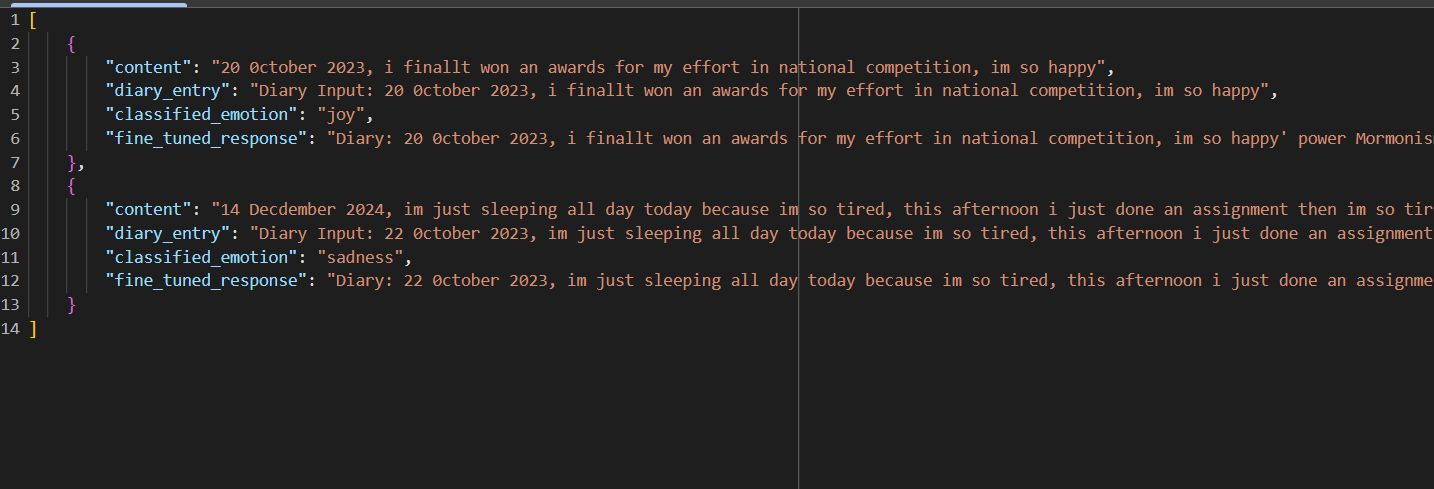